In [1]:
region_name = "ALL_10-800" #"CAINGSGII_10-800"  #"TDS" #"CAINGSGII_10-800"  #"TDS" # "MDIS_10-800" # "TDS" # _ELAISN1
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"
region_fname_rnd = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat_rnd.fits"

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
from astropy.table import unique, Table, hstack, join, setdiff
from astropy import units as uu
from astroquery.simbad import Simbad
from astropy.visualization import quantity_support
from astropy.modeling.models import BlackBody
from astropy import constants as cc
from matplotlib.ticker import ScalarFormatter
from astroquery.sdss import SDSS

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.tables import TableCollection, dd_vasca_columns
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, dd_filter2wavelength, mag2flux, flux2mag, query_vizier_sed, add_ogrp

#from loguru import logger
#logger.enable("vasca")

# Do catalog file
rc = Region()
rc.load_from_fits(region_fname)
rc.copy_table_columns("tt_sources","tt_simbad",["match_distance"],"rg_src_id")
rc.tt_sources.rename_column("match_distance","match_distance_simbad")
display(rc.tt_sources)

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,maincat_match_id,simbad_match_id,gaiadr3_match_id,gfcat_src_id,gfcat_dist,flux_ne,match_distance_simbad
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,arcsec,,arcsec
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,int32,int32,int32,int64,float32,float32[2],float32
-1,187 .. 108,150.194918417219,2.0679206227305555,0.040111132,-0.33596617,0.17920706,1.0,0.31383777,851190,0.15578486,1 .. 2,True,14.337428 .. 8.829313,0.07034474 .. 0.10789034,0.009810384 .. 0.0021278118,3.6502573 .. 2.3919716,0.0 .. 7.7564496e-11,3.610055 .. 2.1373591,0.9321023 .. -100.0,-7.513986 .. -10000.0,-1,108,10,0.6065036,0.008675926,-1,0,0,-1,-1.0,0.099047385 .. 0.04612821,0.7043867
-1,252 .. 147,150.17992517033275,2.1103255556554164,0.035408843,-0.24451591,0.30744642,0.99999994,0.566374,63348,0.13007154,1 .. 2,True,17.587757 .. 6.551935,0.06531105 .. 0.0799764,0.002130574 .. -0.0008621514,2.4555638 .. 1.3940743,1.3690256e-15 .. 0.583465,1.8763659 .. 0.9710373,0.9826826 .. -100.0,-2.812118 .. -10000.0,-1,120,10,0.3645722,0.0049660443,-1,1,1,-1,-1.0,0.046158142 .. --,0.8139196
-1,215 .. 98,150.14575395927176,2.0430717203171844,0.042377234,-0.3888233,0.26905078,1.0,0.41654086,63495,0.12812772,1 .. 2,True,10.116212 .. 3.6047747,0.058852334 .. 0.07647746,0.025982166 .. 0.034063913,3.870571 .. 1.2268405,0.0 .. 4.696414e-06,5.498915 .. 1.7682465,1.0239081 .. -100.0,2.2745934 .. -10000.0,-1,154,10,0.34246105,0.008548844,-1,3,2,-1,-1.0,0.16118984 .. 0.18456411,0.596966
-1,216 .. 31,150.12385136844156,2.3582492060256848,0.05189303,-0.37029192,0.38448596,1.0,0.518402,63605,0.39484766,1 .. 2,True,4.4475236 .. 1.7711709,0.04511629 .. 0.09256162,0.02649166 .. 0.00075723574,1.0877458 .. 0.29965115,1.6119682e-28 .. 0.3227426,2.462556 .. 1.099846,1.0209451 .. 0.7845727,0.88492364 .. -2.5477493,-1,171,10,0.35776442,0.020704556,-1,4,-1,-1,-1.0,0.1627626 .. 0.027517917,0.66436946
-1,254 .. 121,150.10185439309916,2.1056353302221575,0.040247425,-0.21038206,0.539894,0.99994904,0.6663007,5576,0.25821337,1 .. 2,True,9.21146 .. 2.9914618,0.05221208 .. 0.06258586,0.005092152 .. -0.00876606,1.6152399 .. 0.5309438,6.099398e-10 .. 0.8889583,1.6382984 .. 0.84549737,0.9727835 .. 1.0755622,-2.5663564 .. 1.1273481,-1,187,10,0.3268755,0.0076531875,-1,6,3,-1,-1.0,0.071359314 .. --,0.81216687
-1,167 .. 73,149.99381804225305,2.2583590315688093,0.056543395,-0.08191248,0.83849883,0.6568356,0.89119935,64147,0.5602824,1 .. 2,True,6.4463778 .. 2.4059637,0.059417047 .. 0.07284056,0.027545962 .. 0.0045731612,2.074089 .. 0.46929184,0.0 .. 0.081872426,4.7026825 .. 1.2398806,1.0842911 .. -100.0,5.5621567 .. -10000.0,-1,294,10,0.35928774,0.013882067,-1,7,-1,-1,-1.0,0.16596976 .. 0.06762515,0.9804458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,-1 .. 35,4.458705347139129,16.331065543471006,0.08498374,-0.07995764,0.17386477,0.68107635,0.6864786,-1,-1.0,0 .. 2,False,-1.0 .. 541.08575,-1.0 .. 1.1442306,-100.0 .. 0.0043486194,-1.0 .. 1321.8466,-1.0 .. 0.0,-1.0 .. 32.097267,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,2776889,1,-1.0,-1.0,-1,-1,-1,-1,-1.0,-- .. 0.06594406,-1.0


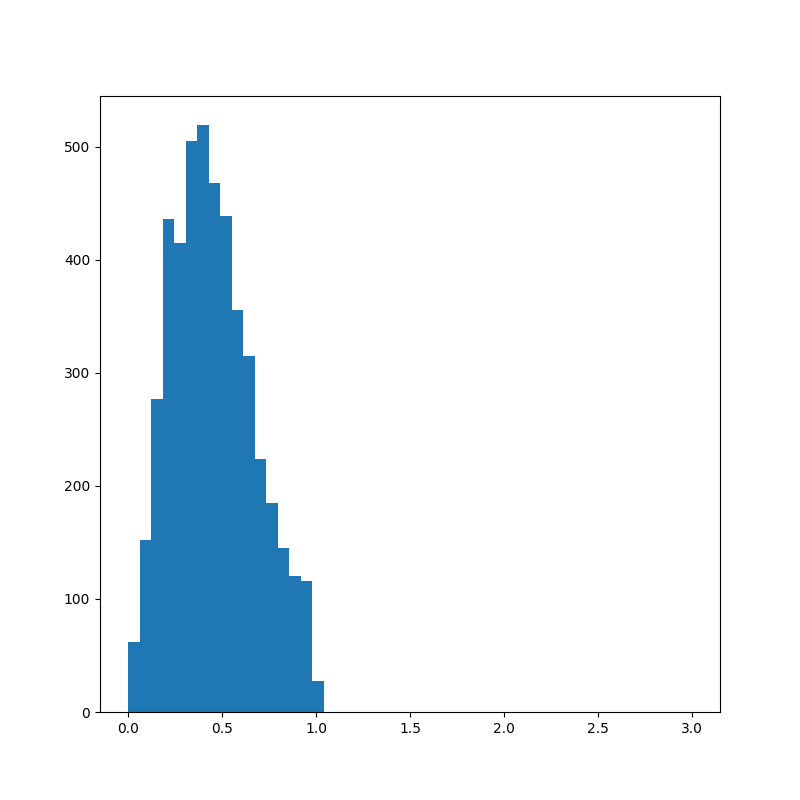

In [5]:
dist_bins = np.linspace(0,3,50)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), clear=True)
_ = ax.hist(rc.tt_sources["match_distance_simbad"], bins=dist_bins)

In [ ]:
#Random shifts
rc_rnd = Region()
rc_rnd.load_from_fits(region_fname_rnd)
nr_src = len(rc_rnd.tt_sources)
shift_dist = 60 # in arcsec
rng = np.random.default_rng(nr_src)
ra_random = rng.uniform(-shift_dist, shift_dist, nr_src) * uu.arcsec
dec_random = rng.uniform(-shift_dist, shift_dist, nr_src) * uu.arcsec

rc_rnd.tt_sources["dec"]=rc_rnd.tt_sources["dec"]+dec_random.to(uu.deg)
rc_rnd.tt_sources["ra"]=(rc_rnd.tt_sources["ra"]+ra_random.to(uu.deg)(np.cos(rc_rnd.tt_sources["dec"]))/